# Dinámicas Económicas Simuladas: Un Modelo Basado en Agentes

En el estudio de la economía, los modelos basados en agentes han ganado popularidad debido a su capacidad para simular el comportamiento individual y colectivo dentro de un mercado. Estos modelos permiten observar y analizar dinámicas complejas que emergen de interacciones simples entre agentes.

Este modelo se fundamenta en el campo de la econofísica, específicamente en un artículo elaborado por [Drăgulescu et al.](https://econpapers.repec.org/paper/arxpapers/cond-mat_2f0211175.htm), el cual proporciona información detallada sobre los supuestos de modelado utilizados.


Los supuestos que rigen este modelo son los siguientes:
1. Existe un número determinado de agentes.
2. Todos los agentes comienzan con una unidad de dinero.
3. En cada iteración del modelo, un agente entrega una unidad de dinero (si la posee) a otro agente.

A pesar de ser un modelo básico, produce resultados interesantes e inesperados.

In [1]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) 
# y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existan más de un agente por celda, elegimos 
# ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen 
# ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso 
# de la simulación.
from mesa.datacollection import DataCollector

# Haremos uso de ''batch_run'' para ejecutar varias simulaciones
from mesa.batchrunner import batch_run

# matplotlib lo usaremos crear una animación de cada uno de los pasos 
# del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# seaborn lo usaremos desplegar una gráficas más ''vistosas'' de 
# nuestro modelo
import seaborn as sns

# Importamos los siguientes paquetes para el mejor manejo de valores 
# numéricos.
import numpy as np
import pandas as pd

In [2]:
class MoneyAgent(Agent):
    '''Un agente con riqueza inicial fija'''
    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
    
    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

In [3]:
class MoneyModel(Model):
    '''Un modelo con algun numero de agentes'''
    def __init__(self, N):
        super().__init__()
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Crear agentes
        for i in range(self.num_agents):
            a = MoneyAgent(self)
            self.schedule.add(a)
            
    def step(self):
        '''Avanzar el modelo un paso'''
        self.schedule.step()

In [4]:
model = MoneyModel(10)
for i in range(10):
    model.step()

/tmp/ipykernel_8967/3188860289.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


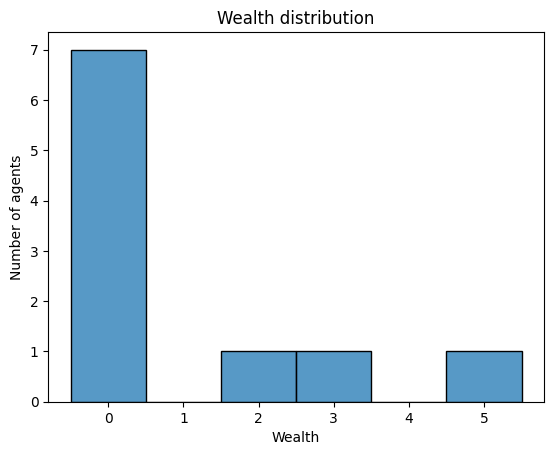

In [5]:
agent_wealth = [a.wealth for a in model.schedule.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", 
    ylabel="Number of agents"
);  # The semicolon is just to avoid printing the object representation

/tmp/ipykernel_8967/3188860289.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


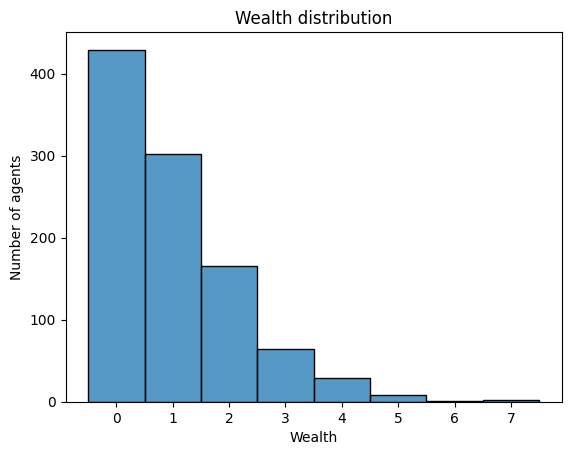

In [6]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", 
      ylabel="Number of agents");

## Modelo extendido

In [7]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        else:
            self.steps_not_given += 1

In [8]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N - i) for i,xi in enumerate(x) ) / (N * sum(x))
    return (1 + (1 / N) - (2 * B))

In [9]:
class MoneyModel(Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        super().__init__()
        
        self.num_agents = N
        
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", 
                             "Steps_not_given": "steps_not_given"})
        
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [10]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

/tmp/ipykernel_8967/1462532135.py:10: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


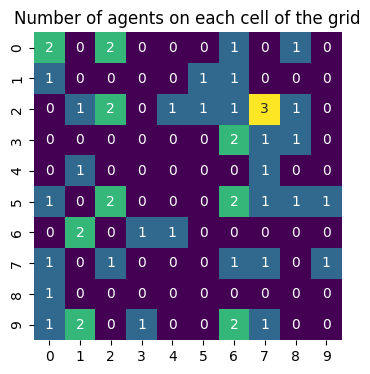

In [11]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, 
                square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

<Axes: >

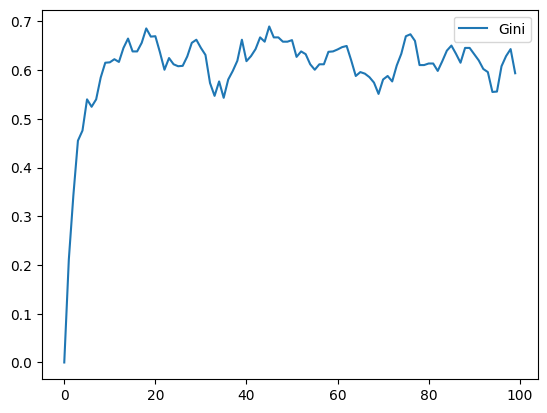

In [12]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [13]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth  Steps_not_given
Step AgentID                         
1    1             1                0
     2             1                0
     3             1                0
     4             1                0
     5             1                0

<Axes: >

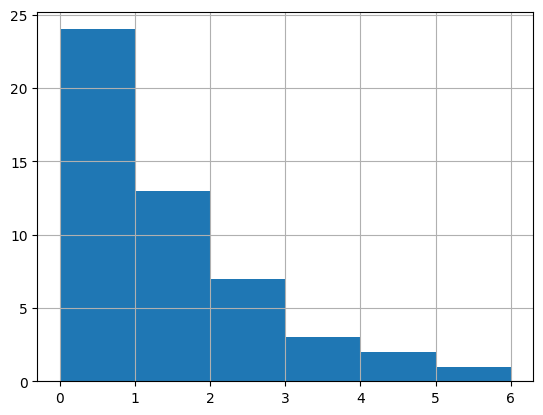

In [14]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

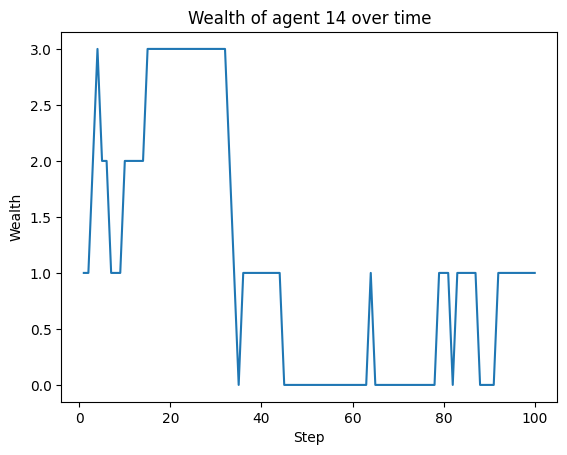

In [15]:
# Get the wealth of agent 14 over time
one_agent_wealth = agent_wealth.xs(14, level="AgentID")

# Plot the wealth of agent 14 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 14 over time");

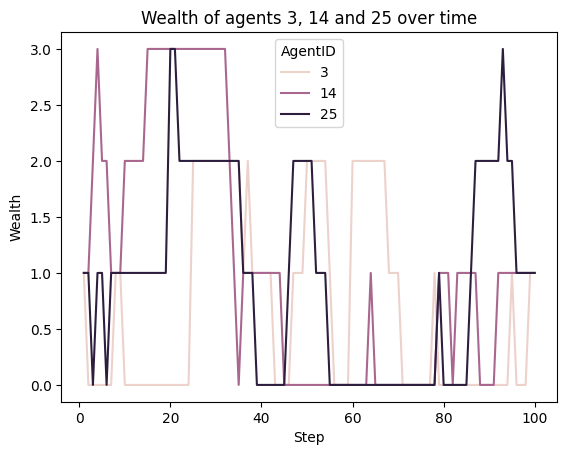

In [16]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", 
                 hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

[Text(0.5, 1.0, 'Average wealth over time')]

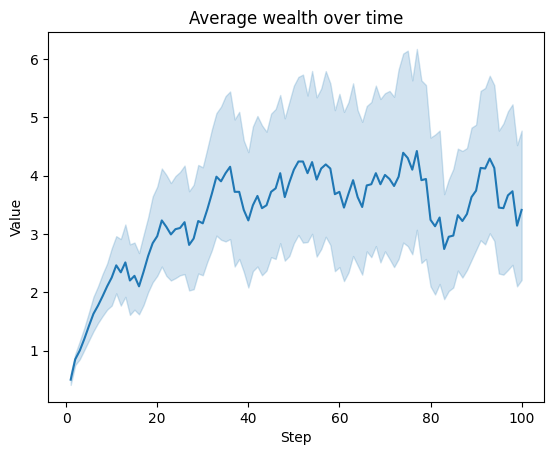

In [17]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", 
                 errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [18]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

## Batch Run

In [19]:
params = {"width": 10, "height": 10, "N": range(5, 100, 5)}

results = batch_run(
    MoneyModel,
    parameters=params,
    iterations=7,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/133 [00:00<?, ?it/s]

/tmp/ipykernel_8967/1462532135.py:10: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


In [27]:
df = pd.DataFrame(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665133 entries, 0 to 665132
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   RunId            665133 non-null  int64  
 1   iteration        665133 non-null  int64  
 2   Step             665133 non-null  int64  
 3   width            665133 non-null  int64  
 4   height           665133 non-null  int64  
 5   N                665133 non-null  int64  
 6   Gini             665133 non-null  float64
 7   AgentID          665000 non-null  float64
 8   Wealth           665000 non-null  float64
 9   Steps_not_given  665000 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 50.7 MB


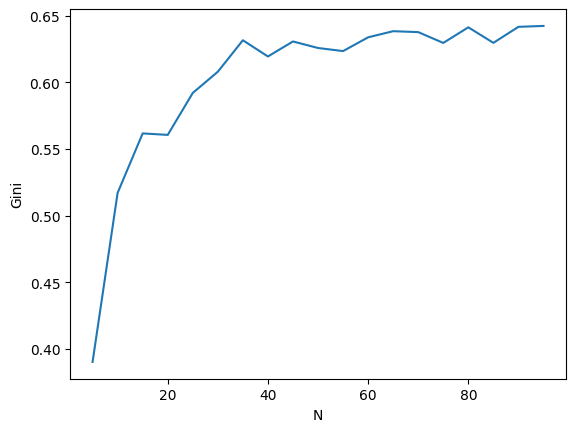

In [28]:
# Calcular el promedio de Gini para cada valor de N
df_avg = df.groupby('N')['Gini'].mean().reset_index()

# Crear el gráfico de línea (line plot) o un gráfico de dispersión dependiendo de lo que prefieras
sns.lineplot(data=df_avg, x='N', y='Gini')
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);